In [1]:
!kaggle datasets download -d landrykezebou/vcor-vehicle-color-recognition-dataset
import zipfile
zip_ref = zipfile.ZipFile('/content/vcor-vehicle-color-recognition-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset
License(s): copyright-authors
 97% 557M/574M [00:05<00:00, 103MB/s]
100% 574M/574M [00:05<00:00, 105MB/s]


In [2]:
import os
import zipfile
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import RandomOverSampler

train_path = '/content/train'
test_path = '/content/test'
val_path = '/content/val'


In [3]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for color_class in os.listdir(folder_path):
        color_path = os.path.join(folder_path, color_class)
        for filename in os.listdir(color_path):
            img = Image.open(os.path.join(color_path, filename)).resize((128, 128))
            img_array = np.array(img)
            images.append(img_array)
            labels.append(1 if color_class == 'blue' else 0)
    return images, labels

train_images, train_labels = load_images_from_folder(train_path)
test_images, test_labels = load_images_from_folder(test_path)
val_images, val_labels = load_images_from_folder(val_path)

images = train_images + test_images + val_images
labels = train_labels + test_labels + val_labels

In [4]:
images_f = np.array(images, dtype=np.float32) / 255.0
labels_f = np.array(labels, dtype=np.int32)  # labels are int

print(images_f.shape)
print(labels_f.shape)

(10373, 128, 128, 3)
(10373,)


In [5]:
del(train_images, train_labels, test_images, test_labels, val_images, val_labels, images, labels)

0


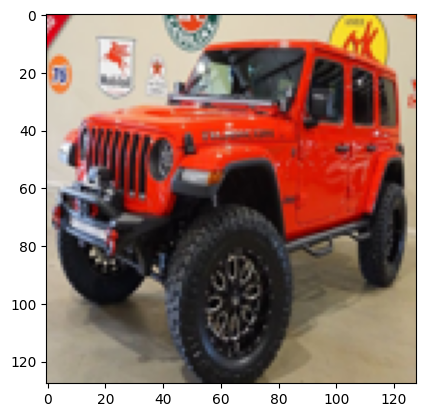

In [48]:
index = 10
plt.imshow(images_f[index])
print(labels_f[index])
plt.show()

In [6]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def create_tf_dataset(images, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

x_train, x_test, y_train, y_test = train_test_split(images_f, labels_f, random_state=100, test_size=0.2)
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

dataset_train = create_tf_dataset(x_train, y_train)
dataset_test = create_tf_dataset(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(8298, 128, 128, 3) (8298,)
(2075, 128, 128, 3) (2075,)


0


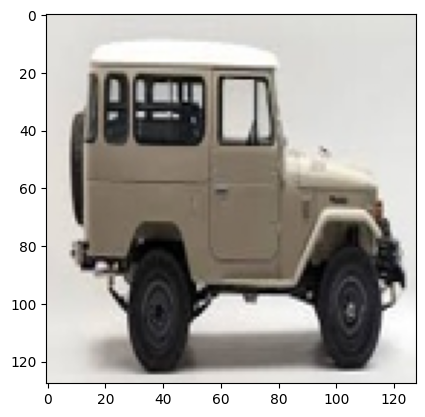

In [50]:
index = 10
plt.imshow(x_train[index])
print(y_train[index])
plt.show()

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0001), input_shape=(128, 128, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,621,377 (10.00 MB)

 Trainable params: 2,619,393 (9.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [52]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

fle_s = 'new_new_model.keras'
checkpoint = ModelCheckpoint(fle_s, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode="auto", save_freq='epoch')
Early_stop = EarlyStopping(patience=30, monitor='val_loss', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5)
callback_list = [checkpoint, Early_stop, lr_scheduler]



In [17]:

history = model.fit(
    dataset_train,
    epochs=150,
    validation_data=dataset_test,
    callbacks=callback_list,
    class_weight=class_weight
)



Epoch 1/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5517 - loss: 1.0842
Epoch 1: val_loss improved from inf to 0.39712, saving model to new_new_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.5520 - loss: 1.0835 - val_accuracy: 0.8911 - val_loss: 0.3971 - learning_rate: 1.0000e-05
Epoch 2/150
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7719 - loss: 0.5459
Epoch 2: val_loss improved from 0.39712 to 0.32011, saving model to new_new_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7720 - loss: 0.5456 - val_accuracy: 0.8911 - val_loss: 0.3201 - learning_rate: 1.0000e-05
Epoch 3/150
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8528 - loss: 0.4001
Epoch 3: val_loss improved from 0.32011 to 0.27250, saving model to new_new_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8529 - loss: 0.3999 - val_accuracy: 0.8945 - val_loss: 0.2725 - learning_rate: 1.0000e-05
Epoch 4/150
259/260 ━━━━━━━━━━━━━━━━━

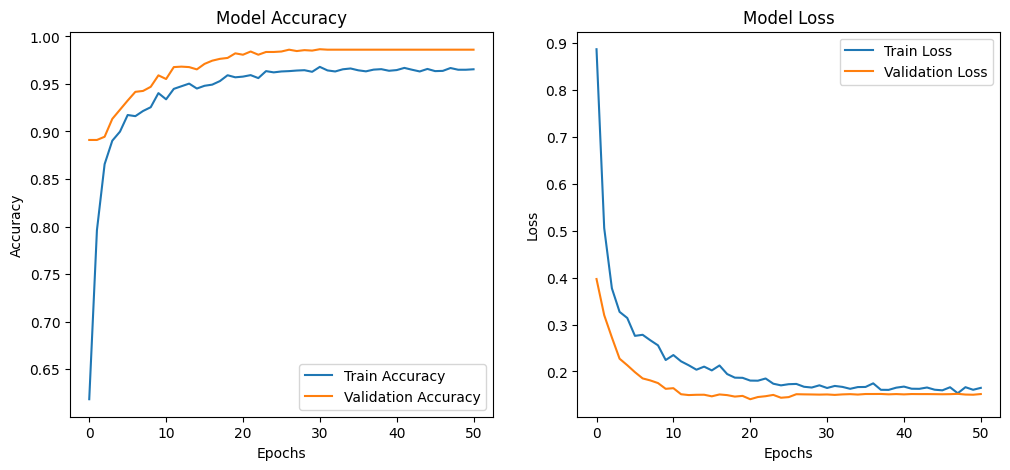

In [18]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [61]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [62]:
y_pred = y_pred.reshape(-1)

In [63]:
y_pred.shape

(2075,)

In [64]:
y_test.shape

(2075,)

In [65]:
mat = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1849
           1       0.96      0.86      0.91       226

    accuracy                           0.98      2075
   macro avg       0.97      0.93      0.95      2075
weighted avg       0.98      0.98      0.98      2075



<Axes: >

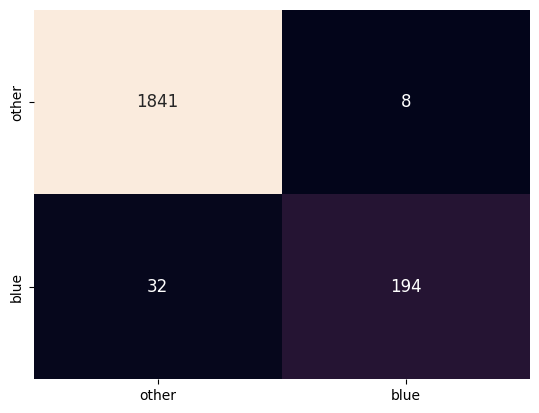

In [66]:
label_to_color = {0: 'other', 1: 'blue'}
sns.heatmap(mat, annot=True, fmt="d",
            xticklabels=label_to_color.values(),
            yticklabels=label_to_color.values(),
            cbar=False, annot_kws={"size": 12})

In [67]:
temp =[]
for i in range(len(labels_f)):
  if labels_f[i] ==1:
    temp.append(int(i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


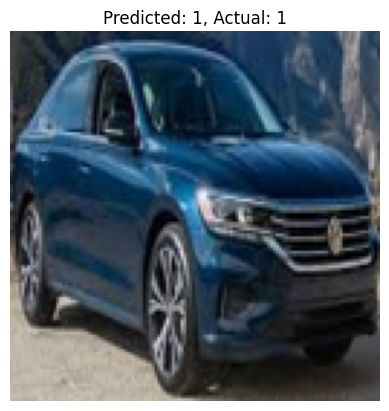

Predicted Probability: [0.5578689], Actual Label: 1


In [70]:
index = 10258  # Select an image index

image = np.expand_dims(images_f[index], axis=0)  # Reshape to (1, 128, 128, 3)

pred = model.predict(image)[0]
pred_label = 1 if pred > 0.5 else 0

plt.imshow(images_f[index])
plt.axis('off')
plt.title(f"Predicted: {pred_label}, Actual: {labels_f[index]}")
plt.show()

print(f"Predicted Probability: {pred}, Actual Label: {labels_f[index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


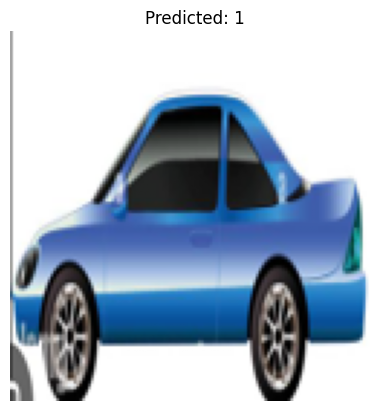

Predicted Probability: [0.85890436]


In [ ]:
img = Image.open('/content/google_image_test').resize((128,128)).convert('RGB')
img = np.array(img) / 255.0  # Normalize the image
image = np.expand_dims(img, axis=0)  # Reshape to (1, 128, 128, 3)

pred = m.predict(image)[0]
pred_label = 1 if pred > 0.5 else 0

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_label}")
plt.show()

print(f"Predicted Probability: {pred}")